In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 7.7 MB/s 


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.image as img
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer
import imageio
import mtcnn
import cv2
import matplotlib
import sys
sys.path.insert(0,'/content/drive/My Drive')
from triplet import batch_hard_triplet_loss
from Res_Model import create_model
%matplotlib inline
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
print(mtcnn.__version__)

def draw_facebox(filename, result_list):
  for result in result_list:
    x, y, width, height = result['box']
    img = Image.open(f"{filename}") 
    img_res = img.crop((x, y, x + 185 ,y + 185))
    return img_res

0.1.0


In [ ]:
def plot_accuracy_threshold(LABEL,IMAGE,model):
  distances = [] 
  identical = [] 

  num = len(LABEL)
  embedded = model.predict(np.array(IMAGE))

  for i in range(num - 1):
    for j in range(1, num):
      distances.append(distance(embedded[i], embedded[j]))
      identical.append(1 if LABEL[i] == LABEL[j] else 0)
        
  distances = np.array(distances)
  identical = np.array(identical)

  thresholds = np.arange(0.3, 1.0, 0.01)

  f1_scores = [f1_score(identical, distances < t) for t in thresholds]
  acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

  opt_idx = np.argmax(f1_scores)

  opt_tau = thresholds[opt_idx]

  opt_acc = accuracy_score(identical, distances < opt_tau)

  
  plt.plot(thresholds, f1_scores, label='F1 score');
  plt.plot(thresholds, acc_scores, label='Accuracy');
  plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
  plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
  plt.xlabel('Distance threshold')
  plt.legend();

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
class TripletLossLayer(Layer):
  
  def __init__(self, alpha, **kwargs):
    self.alpha = alpha
    super(TripletLossLayer, self).__init__(**kwargs)
    
  def triplet_loss(self, inputs):
    labels , embeddings = inputs
    return  batch_hard_triplet_loss(labels, embeddings, margin=.2, squared=False)
    
  def call(self, inputs):
    loss = self.triplet_loss(inputs)
    self.add_loss(loss)
    return loss

In [ ]:

in_p = Input(shape=(185,185,3))
y = Input(shape = (48,1))

nn4_small2 = create_model()

embeddings = nn4_small2(in_p)

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([y , embeddings])
nn4_small2_train = Model(inputs= [in_p , y] , outputs =  [triplet_loss_layer , embeddings])
nn4_small2_train.compile(loss=None, optimizer='adagrad')

In [ ]:
from keras.models import model_from_json

In [ ]:
folder = "/content/drive/MyDrive/face_dataset"

for i in range(160,161):
  LABEL = []
  IMAGE = []
  for filename in os.listdir(folder+f"/{i}"):
    LABEL.append(int(filename.split("_")[0]))  
    pixels = plt.imread(folder+f"/{i}"+f"/{filename}")
    detector = mtcnn.MTCNN()
    faces = detector.detect_faces(pixels)
    IMAGE.append(np.array(draw_facebox(folder+f"/{i}"+f"/{filename}", faces)))
    
  print(f"batch {i}")
  nn4_small2_train.fit([np.array(IMAGE) ,np.array(LABEL)] , epochs=5,steps_per_epoch=10)
  if i%5==0:
    model_json = nn4_small2.to_json()
    with open("/content/drive/MyDrive/FACENET_MODEL/model.json", "w") as json_file:
      json_file.write(model_json)
    nn4_small2.save_weights("/content/drive/MyDrive/FACENET_MODEL/model.h5")
    print("Saved model to disk")

batch 160


Loaded model from disk


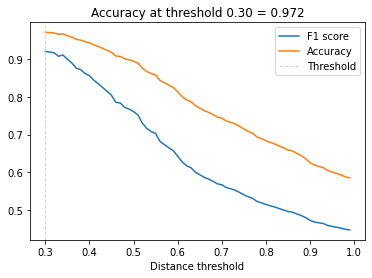

In [ ]:
json_file = open('/content/drive/MyDrive/FACENET_MODEL/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
nn4_small2 = model_from_json(loaded_model_json)
nn4_small2.load_weights("/content/drive/MyDrive/FACENET_MODEL/model.h5")
print("Loaded model from disk")    

plot_accuracy_threshold(LABEL,IMAGE,nn4_small2)